In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

import pickle
import os

torch.backends.cudnn.enabled = False


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

# TASK-1

MODEL-1

In [3]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)
        emotions = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']
        self.emotion_dict = {}
        for i, emotion in enumerate(emotions):
            self.emotion_dict[emotion] = i

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_emotion_matrix(self, row):
        emotions = row['emotions']
        emotion_matrix = np.zeros((len(emotions), 7))
        for idx, emotion in enumerate(emotions):
            emotion_matrix[idx][self.emotion_dict[emotion]] = 1
        return emotion_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_emotion_matrix(self.train_data.iloc[idx])
        return X, Y

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def get_F1(model , dataloader , DEVICE):
    all_predicted=[]
    all_true=[]

    for inputs,labels in dataloader:
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        with torch.no_grad():
            outputs=model(inputs.float())
        predicted=torch.argmax(outputs,dim=2).cpu().numpy().flatten()
        true_labels=torch.argmax(labels,dim=2).cpu().numpy().flatten()
        all_predicted.extend(predicted)
        all_true.extend(true_labels)

    f1_scores_dict = {
        'surprise': f1_score(all_true, all_predicted, labels=[0], average='macro'),
        'neutral': f1_score(all_true, all_predicted, labels=[1], average='macro'),
        'disgust': f1_score(all_true, all_predicted, labels=[2], average='macro'),
        'fear': f1_score(all_true, all_predicted, labels=[3], average='macro'),
        'sadness': f1_score(all_true, all_predicted, labels=[4], average='macro'),
        'anger': f1_score(all_true, all_predicted, labels=[5], average='macro'),
        'joy': f1_score(all_true, all_predicted, labels=[6], average='macro'),
        'overall': f1_score(all_true, all_predicted, average='macro')
    }    

    cm = confusion_matrix(all_true, all_predicted)

    print(f1_scores_dict)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return 

In [5]:
class ERC_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(ERC_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)
        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768
cnn_mid_channels = 3
cnn_out_channels = 1
hidden_lstm = 64
layers_lstm = 1
inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 7
    
folder_path = ""
path_train_file = folder_path+"train_file.json"

dataset = MyDataset(path_train_file)
criterion = nn.CrossEntropyLoss().to(DEVICE)

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_dataset = MyDataset(folder_path+"val_file.json")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

state_dict = torch.load('M1.pth')
model.load_state_dict(state_dict)

model = model.to(DEVICE)

l = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']

model.eval()

ERC_CNN(
  (conv1): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

{'surprise': 0.9597597597597598, 'neutral': 0.9959660047781302, 'disgust': 0.8834173835657075, 'fear': 0.8479435957696826, 'sadness': 0.944555778223113, 'anger': 0.9622917275650396, 'joy': 0.9860460803857031, 'overall': 0.9399971900067338}


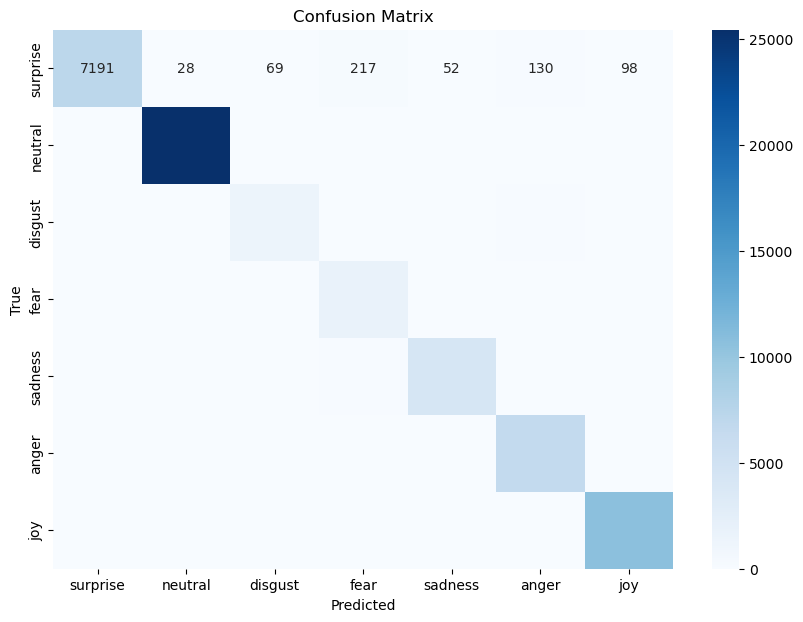

In [6]:
get_F1(model , dataloader , DEVICE)

{'surprise': 0.9419759539989545, 'neutral': 0.9911173445535297, 'disgust': 0.8373205741626795, 'fear': 0.8070175438596492, 'sadness': 0.9146005509641872, 'anger': 0.9389788293897884, 'joy': 0.9825119236883944, 'overall': 0.9162175315167403}


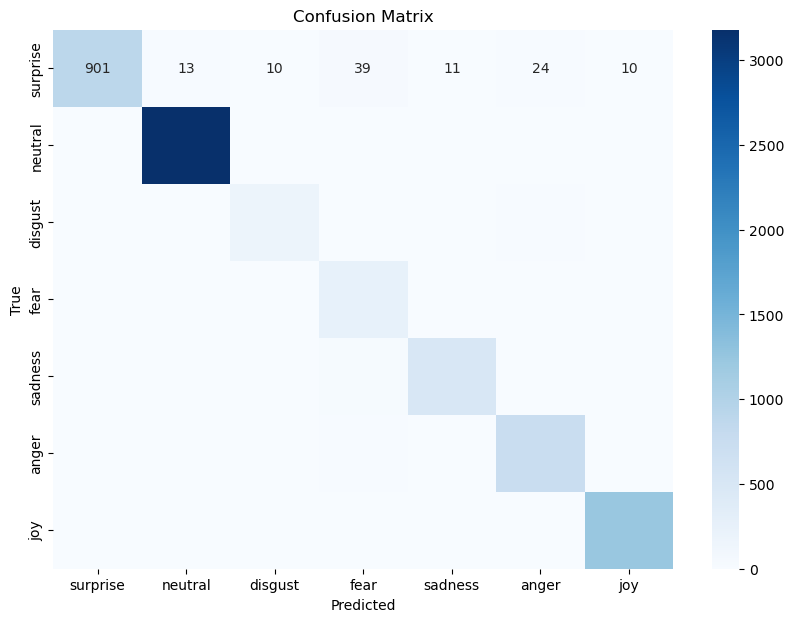

In [7]:
get_F1(model , val_dataloader , DEVICE)

MODEL-2

In [11]:
class ERC_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(ERC_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [12]:
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = folder_path+"train_file.json"

dataset = MyDataset(path_train_file)
criterion = nn.CrossEntropyLoss().to(DEVICE)

model = ERC_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

state_dict = torch.load('M2.pth')
model.load_state_dict(state_dict)

model = model.to(DEVICE)

l = ['surprise', 'neutral', 'disgust', 'fear', 'sadness', 'anger', 'joy']

model.eval()

def get_F1(model , dataloader , DEVICE):
    all_predicted=[]
    all_true=[]

    for inputs,labels in dataloader:
        inputs=inputs.to(DEVICE)
        labels=labels.to(DEVICE)
        with torch.no_grad():
            outputs=model(inputs.float())
        predicted=torch.argmax(outputs,dim=2).cpu().numpy().flatten()
        true_labels=torch.argmax(labels,dim=2).cpu().numpy().flatten()
        all_predicted.extend(predicted)
        all_true.extend(true_labels)

    f1_scores_dict = {
        'surprise': f1_score(all_true, all_predicted, labels=[0], average='macro'),
        'neutral': f1_score(all_true, all_predicted, labels=[1], average='macro'),
        'disgust': f1_score(all_true, all_predicted, labels=[2], average='macro'),
        'fear': f1_score(all_true, all_predicted, labels=[3], average='macro'),
        'sadness': f1_score(all_true, all_predicted, labels=[4], average='macro'),
        'anger': f1_score(all_true, all_predicted, labels=[5], average='macro'),
        'joy': f1_score(all_true, all_predicted, labels=[6], average='macro'),
        'overall': f1_score(all_true, all_predicted, average='macro')
    }    

    cm = confusion_matrix(all_true, all_predicted)

    print(f1_scores_dict)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return 

{'surprise': 0.9200771668733637, 'neutral': 0.9848954374476213, 'disgust': 0.7360912981455064, 'fear': 0.6566948999819788, 'sadness': 0.8948886581285336, 'anger': 0.9335826477187733, 'joy': 0.9688954426063314, 'overall': 0.8707322215574441}


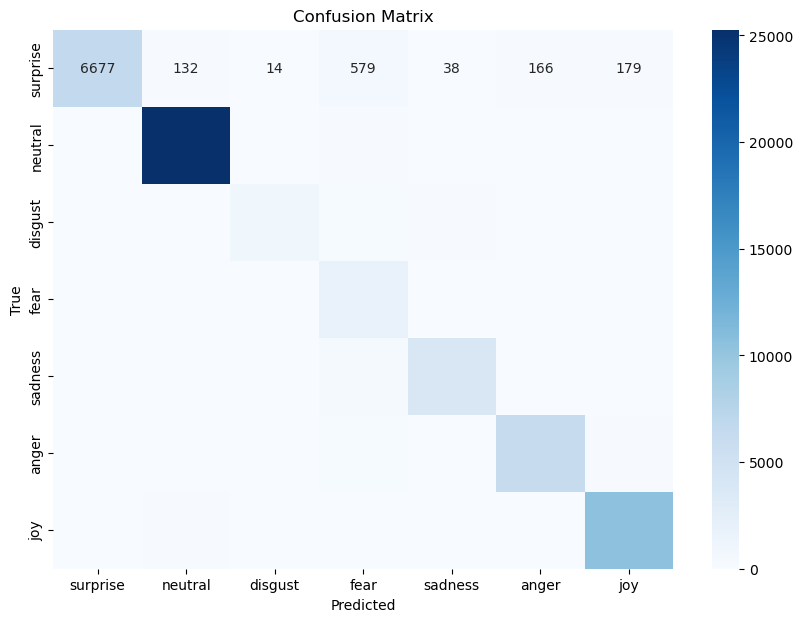

In [13]:
get_F1(model , dataloader , DEVICE)

{'surprise': 0.9107429182255479, 'neutral': 0.9771703680695761, 'disgust': 0.7246376811594203, 'fear': 0.6282853566958698, 'sadness': 0.8713060057197332, 'anger': 0.9097988319273199, 'joy': 0.956726986624705, 'overall': 0.8540954497745961}


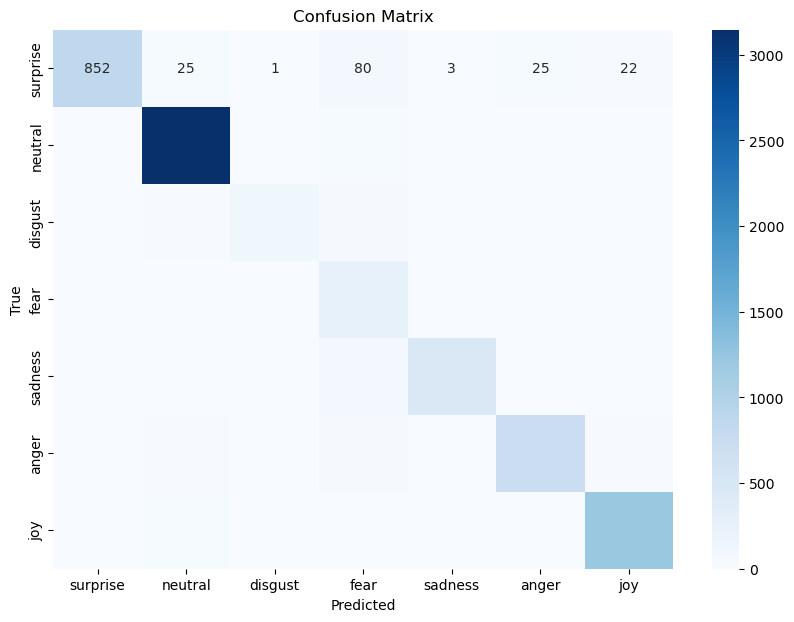

In [14]:
get_F1(model , val_dataloader , DEVICE)

# Task-2

Model-3

In [15]:
class EFR_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(EFR_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_trigger_matrix(self, row):
        triggers = row['triggers']
        trigger_matrix = np.zeros((len(triggers), 2))
        for idx, trigger in enumerate(triggers):
            if trigger is None:
                trigger = 0
            trigger_matrix[idx][int(trigger)] = 1
        return trigger_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_trigger_matrix(self.train_data.iloc[idx])
        # print(X.shape, Y.shape)
        return X, Y
    
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_triggers = 2


# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

folder_path = ""

path_train_file = "train_file.json"
path_val_file = "val_file.json"

dataset = MyDataset(path_train_file)
val_dataset = MyDataset(path_val_file)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


model.load_state_dict(torch.load('m3.pth'))
model.to(DEVICE)
model.eval()

def get_F1(data_loader , model): 
    predictions = []
    true_labels = []
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels[:, :, 1].type(torch.LongTensor).to(DEVICE)
        outputs = model(inputs.float())
        pred = outputs.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
    print("F1 Score: ", f1_score(true_labels, predictions, average='macro'))
    confusion_matrix(true_labels, predictions)

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True , fmt = 'd')
    plt.title("0-> No Trigger, 1-> Trigger")

    # add labels for predicted and true values
    plt.xlabel('Predicted')

    plt.ylabel('True')

    
    plt.show()




100%|██████████| 6740/6740 [03:46<00:00, 29.71it/s]


F1 Score:  0.5829718756921273


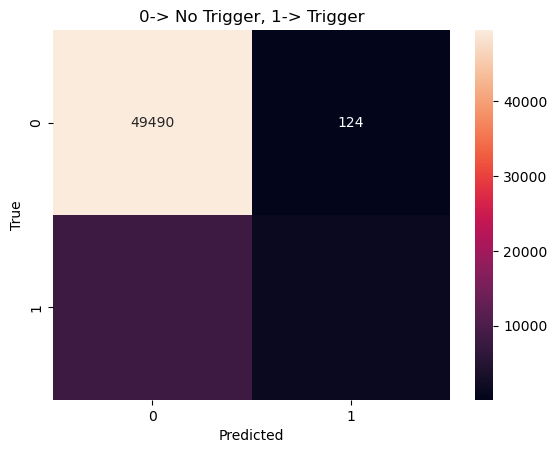

In [16]:
get_F1(dataloader, model)

100%|██████████| 843/843 [00:28<00:00, 30.10it/s]


F1 Score:  0.5813509828901917


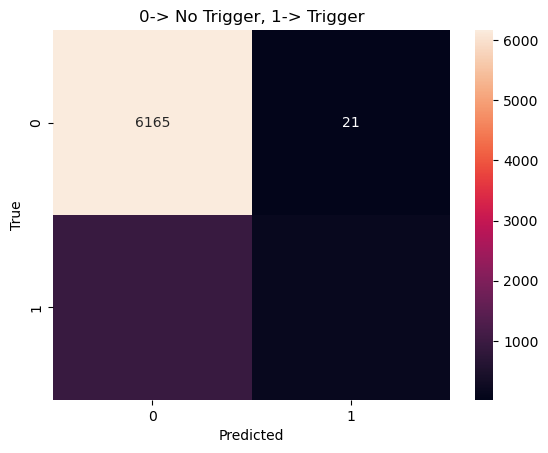

In [17]:
get_F1(val_data_loader, model)

Model-4

In [18]:

class EFR_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(EFR_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_trigger_matrix(self, row):
        triggers = row['triggers']
        trigger_matrix = np.zeros((len(triggers), 2))
        for idx, trigger in enumerate(triggers):
            if trigger is None:
                trigger = 0
            trigger_matrix[idx][int(trigger)] = 1
        return trigger_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_trigger_matrix(self.train_data.iloc[idx])
        # print(X.shape, Y.shape)
        return X, Y
    
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_triggers = 2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)


folder_path = ""

path_train_file = "train_file.json"
path_val_file = "val_file.json"

dataset = MyDataset(path_train_file)
val_dataset = MyDataset(path_val_file)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model.load_state_dict(torch.load(folder_path + 'M4.pth'))
model.eval()


model.load_state_dict(torch.load('M4.pth'))
model.to(DEVICE)
model.eval()

def get_F1(data_loader , model): 
    predictions = []
    true_labels = []
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels[:, :, 1].type(torch.LongTensor).to(DEVICE)
        outputs = model(inputs.float())
        pred = outputs.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
    print("F1 Score: ", f1_score(true_labels, predictions, average='macro'))
    confusion_matrix(true_labels, predictions)

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True , fmt = 'd')
    plt.title("0-> No Trigger, 1-> Trigger")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    plt.show()


100%|██████████| 6740/6740 [03:47<00:00, 29.69it/s]


F1 Score:  0.7490111759176963


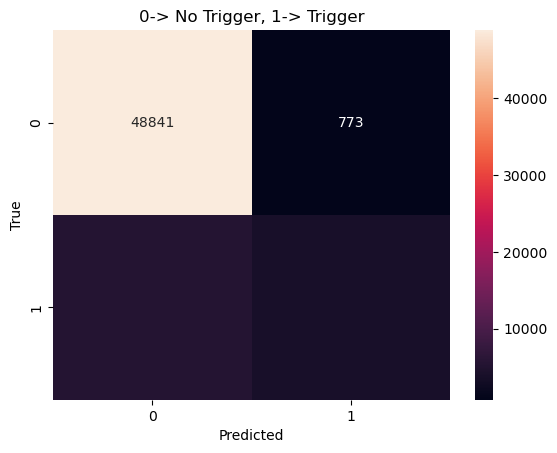

In [19]:
get_F1(dataloader, model)

100%|██████████| 843/843 [00:29<00:00, 28.91it/s]


F1 Score:  0.7210937052935437


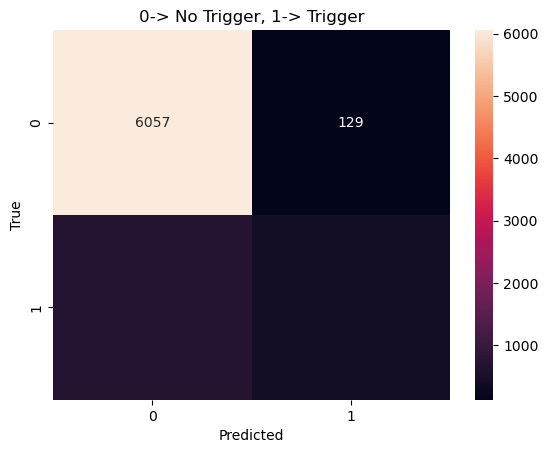

In [20]:
get_F1(val_data_loader, model)